In [1]:
import emcee
print(emcee.__version__)

3.0rc2


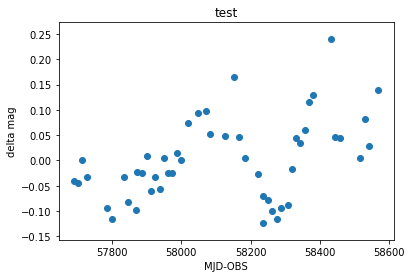

In [16]:
# 15-Sep-2019
# Bo Milvang-Jensen
# Very rudimentary script to read+plot ...

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

0.0001352514476314573 -7.859035245456346


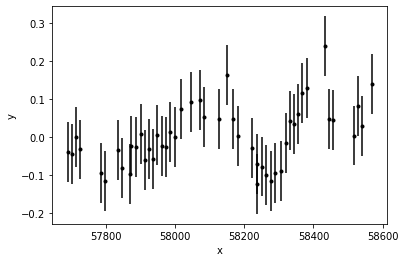

In [59]:
import numpy as np
import matplotlib.pyplot as plt

#data for the model.
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = np.std(y)*np.ones(len(y))


mt = (len(x) * np.sum(x*y) - np.sum(x) * np.sum(y))/(len(x)*np.sum(x*x) - np.sum(x) ** 2)
bt = (np.sum(y) - mt *np.sum(x)) / len(x)
print(mt,bt)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y");

Least-squares estimates:
Value Uncertainty
0.0001352514476307563 4.5417470820844364e-05
-7.859035245415606 2.639620099100878


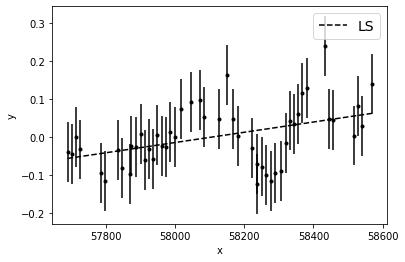

In [61]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("Value Uncertainty")
print(w[0], np.sqrt(cov[0, 0]))
print(w[1], np.sqrt(cov[1, 1]))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(min(x), max(x), 500)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [32]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

In [71]:
mg=(y[-1]-y[0])/(x[-1]-x[0])
bg=y[0]-mg*x[0]
f_true = 0.534
print(mg, bg)

0.0002039258473838262 -11.80472857712242


0.1390819549560547

Maximum likelihood estimates:
0.0002034595980119555
-11.81855586200218
0.572663667131811


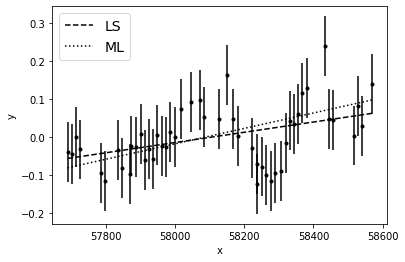

In [86]:
from scipy.optimize import minimize
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([mg, bg, np.log(f_true)]) + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print(m_ml)
print(b_ml)
print(np.exp(log_f_ml))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [87]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 5.0 and -20.0 < b < 20.0 and -10.0 < log_f < 10.0:
        return 0.0
    return -np.inf

In [88]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [89]:
pos = soln.x + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, 5000,progress=True);

C:\Users\Ejer\Anaconda3\lib\site-packages\emcee-3.0rc2-py3.7.egg\emcee\ensemble.py:258: RuntimeWarning: Initial state is not linearly independent and it will not allow a full exploration of parameter space
  category=RuntimeWarning,
100%|██████████| 5000/5000 [00:34<00:00, 146.52it/s]


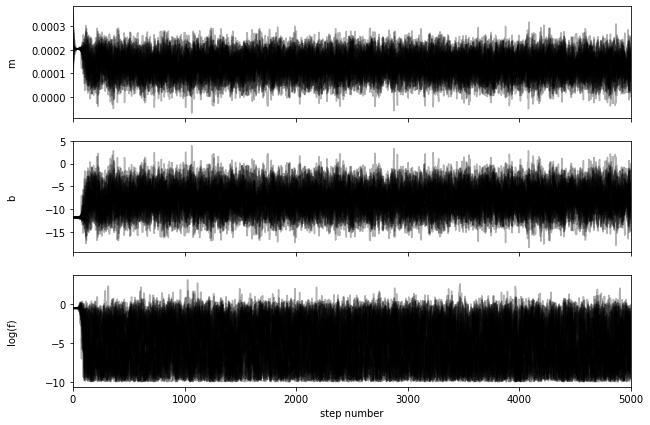

In [90]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [91]:
tau = sampler.get_autocorr_time()
print(tau)

[44.71851522 44.82951159 54.38568447]


In [92]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


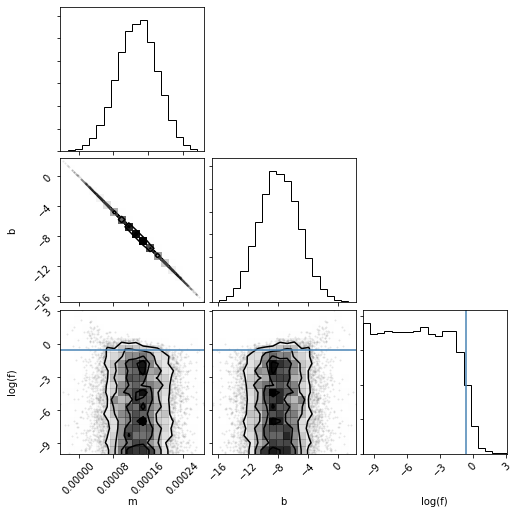

In [93]:
import corner
fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]);

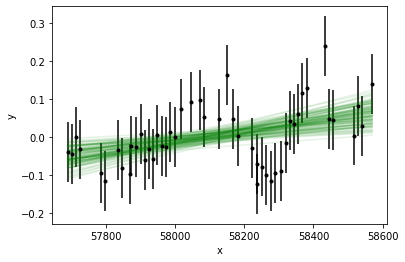

In [94]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "g", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#plt.plot(x0, m_true*x0+b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [95]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>